In [1]:
import numpy as np
import h5py
import math
import os
import pathlib
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense,ZeroPadding2D, BatchNormalization, Activation, Layer, ReLU, LeakyReLU,Conv2D,AveragePooling2D,UpSampling2D,Reshape,Flatten
from tensorflow.keras import backend as K

2025-06-23 13:35:33.335124: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
file_dict = {
    'Background': '/tmp/background_for_training.h5',
    'Ato4l': '/tmp/Ato4l_lepFilter_13TeV_filtered.h5',
    'hChToTauNu': '/tmp/hChToTauNu_13TeV_PU20_filtered.h5',
    'hToTauTau' : '/tmp/hToTauTau_13TeV_PU20_filtered.h5', 
    'leptoquark': '/tmp/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
}

background_file = "/tmp/background_for_training.h5" # background data file

signal_files = [ # signal data files
    '/tmp/Ato4l_lepFilter_13TeV_filtered.h5',
    '/tmp/hChToTauNu_13TeV_PU20_filtered.h5',
    '/tmp/hToTauTau_13TeV_PU20_filtered.h5', 
    '/tmp/leptoquark_LOWMASS_lepFilter_13TeV_filtered.h5',
]
output_bkg_name = 'output_background'

output_signal_names = [ # names for output files
    "output_Ato4l_lepFilter",
    "output_hChToTauNu",
    "output_hToTauTau",
    "output_leptoquark_LOWMASS"
]

In [ ]:
def mse_loss(true, prediction):
    mse = np.mean(np.square(true - prediction), axis=1)  
    return mse

In [4]:
def create_datasets_convolutional(bkg_file, output_bkg_name, signals_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57):
    
    # read BACKGROUND data
    with h5py.File(bkg_file, 'r') as file:
        full_data = file['Particles'][:,:,:-1]
        np.random.shuffle(full_data)
        if events: full_data = full_data[:events,:,:]
    
    # define training, test and validation datasets
    X_train, X_test = train_test_split(full_data, test_size=test_size, shuffle=True)
    X_train, X_val = train_test_split(X_train, test_size=val_size)

    del full_data
    
    with h5py.File(output_bkg_name + '_dataset.h5', 'w') as h5f:
        h5f.create_dataset('X_train', data = X_train)
        h5f.create_dataset('X_test', data = X_test)
        h5f.create_dataset('X_val', data = X_val)
    
    if signals_files:
        # read SIGNAL data
        for i, signal_file in enumerate(signals_files):
            f = h5py.File(signal_file,'r')
            signal_data = f['Particles'][:,:,:-1]
            with h5py.File(output_signal_names[i] + '_dataset.h5', 'w') as h5f2:
                h5f2.create_dataset('Data', data = signal_data)
        
    return

In [ ]:
create_datasets_convolutional(background_file, output_bkg_name, signal_files, output_signal_names, events=None, test_size=0.2, val_size=0.2, input_shape=57)

In [5]:
background = '/home/s1974482/MScDissertation/MScDissertation/MScDissertation-1/output_background_dataset.h5' # path to the background dataset file

# load background training data
with h5py.File(background, 'r') as file:
    X_train = np.array(file['X_train'])
    X_test = np.array(file['X_test'])
    X_val = np.array(file['X_val'])

print(X_train.shape)
X_train = np.reshape(X_train, (-1, 19,3,1))
X_test = np.reshape(X_test, (-1, 19,3,1))
X_val = np.reshape(X_val, (-1, 19,3,1))

print(X_train.shape)

(64000, 19, 3)
(64000, 19, 3, 1)


In [6]:
image_shape = (19,3,1)
latent_dimension = 8
num_nodes=[16,8]

In [7]:
#encoder
input_encoder = Input(shape=(image_shape))
x = Conv2D(10, kernel_size=(3, 3),
         use_bias=False, data_format='channels_last', padding='same')(input_encoder)
x = AveragePooling2D(pool_size = (2, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Flatten()(x)
x = Dense(latent_dimension)(x)
enc = Activation('relu')(x)
encoder = Model(inputs=input_encoder, outputs=enc)
#decoder
x = Dense(270)(enc)
x = Activation('relu')(x)
x = Reshape((9,3,10))(x)
x = UpSampling2D((2, 1))(x)
x = ZeroPadding2D(((1, 0),(0,0)))(x)
x = Conv2D(1, kernel_size=(3,3), use_bias=False, data_format='channels_last', padding='same')(x)
x = BatchNormalization()(x)
dec = Activation('relu')(x)

autoencoder = Model(inputs=input_encoder, outputs=dec)
autoencoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 19, 3, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 19, 3, 10)      │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 9, 3, 10)       │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 9, 3, 10)       │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 9, 3, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │         2,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 270)            │         2,430 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 270)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 9, 3, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 18, 3, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 19, 3, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 3, 1)       │            90 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 3, 1)       │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 19, 3, 1)       │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,822 (18.84 KB)

 Trainable params: 4,800 (18.75 KB)

 Non-trainable params: 22 (88.00 B)

In [8]:

autoencoder.compile(optimizer = keras.optimizers.Adam(), loss='mse')

In [9]:
EPOCHS = 10
BATCH_SIZE = 1024

In [10]:
history = autoencoder.fit(X_train, X_train, epochs = EPOCHS, batch_size = BATCH_SIZE,
                  validation_data=(X_val, X_val))

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 114.4510 - val_loss: 116.4877
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 104.4857 - val_loss: 112.2491
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 99.6062 - val_loss: 106.1481
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 100.6309 - val_loss: 99.6237
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 97.0452 - val_loss: 94.8827
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 96.0794 - val_loss: 91.5444
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 93.3585 - val_loss: 89.2941
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 90.4230 - val_loss: 87.6699
Epoch 9/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 91.3101 - val_loss: 86.4114
Epoch 10/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 88.5909 - val_loss: 85.3078


In [11]:
autoencoder.save('/tmp/CNN_AE.h5')

In [12]:
bkg_prediction = autoencoder.predict(X_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [13]:
signals_file = [ # add correct path to signal files (OUTPUTS)
    '/home/s1974482/MScDissertation/MScDissertation/MScDissertation-1/output_Ato4l_lepFilter_dataset.h5',
    '/home/s1974482/MScDissertation/MScDissertation/MScDissertation-1/output_hChToTauNu_dataset.h5',
    '/home/s1974482/MScDissertation/MScDissertation/MScDissertation-1/output_hToTauTau_dataset.h5', 
    '/home/s1974482/MScDissertation/MScDissertation/MScDissertation-1/output_leptoquark_LOWMASS_dataset.h5',
]

signal_labels = [
    "Ato4l_lepFilter",
    "hChToTauNu",
    "hToTauTau",
    "leptoquark_LOWMASS"
]

In [14]:
# read signal data
signal_data = []
for i, path in enumerate(signals_file):
    with h5py.File(path, 'r') as file:
        test_data = np.array(file['Data'])
        test_data = np.reshape(test_data, (-1, 19, 3, 1))  # reshape to (N, 19, 3, 1)
    signal_data.append((signal_labels[i], test_data))  # pair label with data

In [15]:
for label, data in signal_data:
    print(f"{label}: {data.shape}")

Ato4l_lepFilter: (55969, 19, 3, 1)
hChToTauNu: (760272, 19, 3, 1)
hToTauTau: (691283, 19, 3, 1)
leptoquark_LOWMASS: (340544, 19, 3, 1)


In [16]:
signal_results = []

for label, data in signal_data:
    prediction = autoencoder.predict(data)
    signal_results.append([label, data, prediction]) # save [label, true, prediction] for signal

1750/1750 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
23759/23759 ━━━━━━━━━━━━━━━━━━━━ 75s 3ms/step
21603/21603 ━━━━━━━━━━━━━━━━━━━━ 68s 3ms/step
10642/10642 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step


In [17]:
save_file = 'cnnvae_results'

with h5py.File(save_file, 'w') as file: # overwriting existing file with same name 
    file.create_dataset('BKG_input', data=X_test) # creates dataset inside HDF5 file with name 'BKG_input' (stores background input data- used for training)
    file.create_dataset('BKG_predicted', data = bkg_prediction) # new dataset 'BKG_predicted' (stores background predicted (reconstructed output data)
    for i, sig in enumerate(signal_results): # loops through signal results | Each sig is a list or tuple: [label, original_data, predicted_data]
        file.create_dataset('%s_input' %sig[0], data=sig[1]) # creates dataset for each signal input data - 0 is signal label, 1 is original data
        file.create_dataset('%s_predicted' %sig[0], data=sig[2]) # creates dataset for each signal predicted data - 0 is signal label, 2 is predicted data

In [31]:
print(X_test.shape[0])
print(X_test.shape[1])
print(X_test.shape[2])

print(bkg_prediction.shape[0])
print(bkg_prediction.shape[1])
print(bkg_prediction.shape[2])

for i, (label, signal_X) in enumerate(signal_data):
    print(signal_X.shape[0])
    print(signal_X.shape[1])
    print(signal_X.shape[2])

20000
19
3
20000
19
3
55969
19
3
760272
19
3
691283
19
3
340544
19
3


In [34]:
# compute loss value (true, predicted)
total_loss = []
total_loss.append(mse_loss(X_test.reshape((X_test.shape[0],57)),
                           (bkg_prediction.reshape((bkg_prediction.shape[0],57))).astype(np.float32)).numpy())
for i, (label, signal_X) in enumerate(signal_data):
    total_loss.append(
        mse_loss(
            signal_X.reshape((signal_X.shape[0],57)),
                              (signal_results[i][2].reshape((signal_X.shape[0],57))).astype(np.float32)).numpy()
                            )
    
    print(total_loss)

[array([113.40323815,  23.1936231 ,  54.52682636, ...,  59.90584444,
       102.13735877, 822.92644527]), array([125.22451399, 162.9682387 ,  60.93177145, ..., 261.94621082,
       461.90428193,  57.09135706])]
[array([113.40323815,  23.1936231 ,  54.52682636, ...,  59.90584444,
       102.13735877, 822.92644527]), array([125.22451399, 162.9682387 ,  60.93177145, ..., 261.94621082,
       461.90428193,  57.09135706]), array([102.18449269, 298.48754996, 212.78575574, ..., 175.08721137,
       488.34022263, 276.28075528])]
[array([113.40323815,  23.1936231 ,  54.52682636, ...,  59.90584444,
       102.13735877, 822.92644527]), array([125.22451399, 162.9682387 ,  60.93177145, ..., 261.94621082,
       461.90428193,  57.09135706]), array([102.18449269, 298.48754996, 212.78575574, ..., 175.08721137,
       488.34022263, 276.28075528]), array([139.69114362,  97.18017429,  16.3356428 , ...,  30.74957118,
       155.71902299, 127.16366827])]
[array([113.40323815,  23.1936231 ,  54.52682636, ..

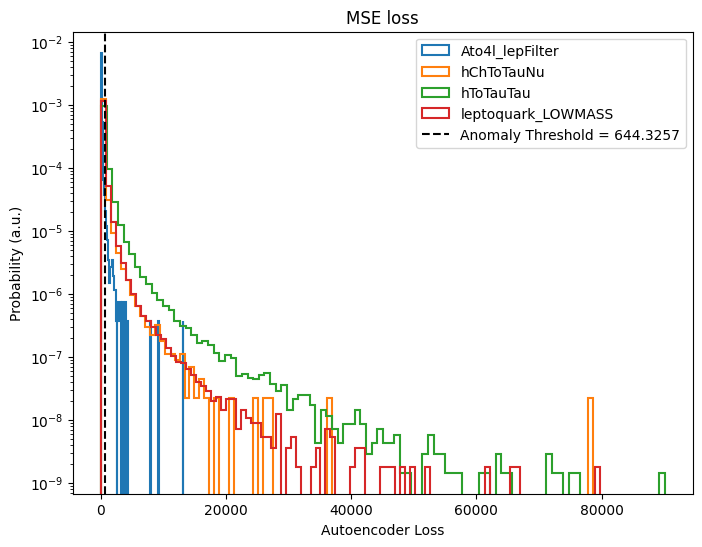

In [35]:
bin_size=100

plt.figure(figsize=(8,6))
for i, label in enumerate(signal_labels):
    plt.hist(total_loss[i], bins=bin_size, label=label, density = True, histtype='step', fill=False, linewidth=1.5)

threshold = np.percentile(total_loss[0], 99)
plt.axvline(threshold, color='black', linestyle='dashed', label=f"Anomaly Threshold = {threshold:.4f}") #adding threshold line
plt.yscale('log')
plt.xlabel("Autoencoder Loss")
plt.ylabel("Probability (a.u.)")
plt.title('MSE loss')
plt.legend(loc='best')
plt.show()

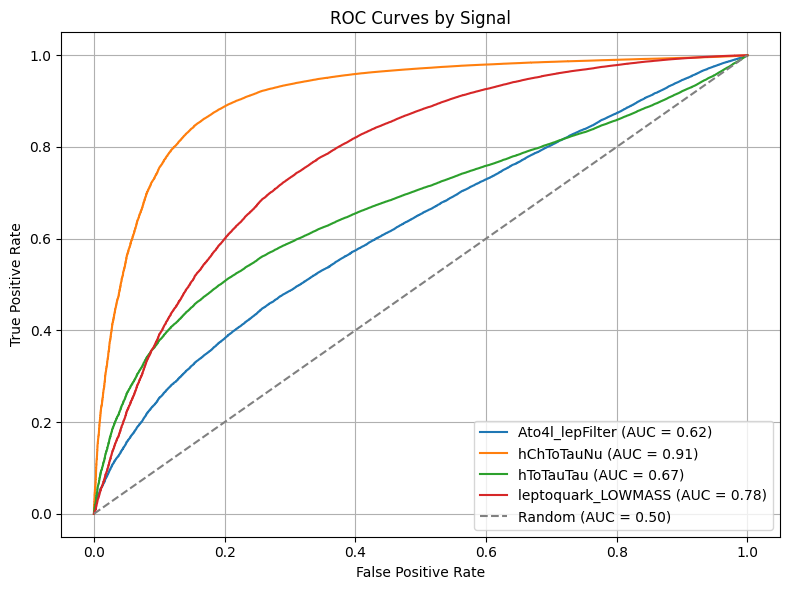

In [ ]:
bkg_loss = total_loss[0]
signal_losses = total_loss[1:]

plt.figure(figsize=(8, 6))
for i, signal_loss in enumerate(signal_losses):
    label = signal_labels[i]  # name of the signal

    # Ground truth: 0 = background, 1 = this signal
    y_true = np.concatenate([
        np.ones(len(signal_loss)),     # signal = 1
        np.zeros(len(bkg_loss))        # background = 0
    ])

    # Scores (MSE loss values): signal + background
    y_scores = np.concatenate([
        signal_loss,
        bkg_loss
    ])

    # Compute ROC and AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    auc_score = auc(fpr, tpr)

    # Plot ROC curve for this signal
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})", linewidth=1.5)

# Reference line (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random (AUC = 0.50)')

# Plot formatting
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Signal")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
